# Mental Health in the Tech Industry Analysis

---
## Sources and Links
Kaggle dataset : [Mental Health in the Tech Industry](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry)

Website used to create ERD : [dbdiagram.io](https://dbdiagram.io)

---
# Overview

- title
- sources and links
- overview
- imports

- business understanding
    - business objectives
    - situation assesment
    - data mining goals
    
    - project plan
- data understanding
    - data properties
    
    - ERD
- methodoligy
- functions
- exploritory data analysis
- data insight
    - gender and age spread
    - industry representation
    
    - mental health
        - age
        - gender
        
        - job type

---
# Imports

Here we import the necessary libraries to understand the data as well as alter it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from pandasql import sqldf
from datetime import datetime

In [2]:
# this cell is just to show the last time this notebook was updated
now = datetime.now()
print(f'This notebook was last updated at : {now} PST')

This notebook was last updated at : 2026-02-15 17:55:48.780899 PST


---
# Business understanding

This notebook is designed to look into the mental health of those who primarily work within the tech industry. This data then can be used to assist thoese who are struggling with mental health issues and get them the help they need. 

- business objectives 
    - quantify mental health within the workplace
        - success is identifying patterns that cause issues and minimizing said causes
- situation assesment 
    - resources available
        - survey answers from 2693 individuals
    - resources unavailable
        - metadata on encoded data such as what 1, 0 and -1 mean
        - whether this data is real or created
        - specific location on where this data was gathered
- data mining goals
    - asses and understand the data provided
- project plan
    - utilize this survey to understand the needs of those struggling with mental health

---
# Data Understanding

The data within this notebook is gathered from [Kaggle](https://www.kaggle.com). The data is as follows :

- data properties 
    - this data is stored as a `sqlite` file, meaning it is comprised of multiple tables that all relate to each other
    - the tables consist of :
        - `Answer`
            - _AnswerText_
                - response given by the user
            - _SurveyID_
                - survey id is the year the survey took place
            - _UserID_
                - identifier of who took the survey
            - _QuestionID_
                - id of the specific question
        - `Question`
            - _QuestionText_
                - the question the user answered
            - _QuestionId_
                - id of the specific question
        - `Survey`
            - _SurveyID_
                - survey id is the year the survey took place
            - _Description_
                - description of the survey

Here we have an `Entity Relationship Diagram` or `ERD` for short. This is a visual representation of how the tables in our SQL file are connected. Link above in the _sources and links_ section.

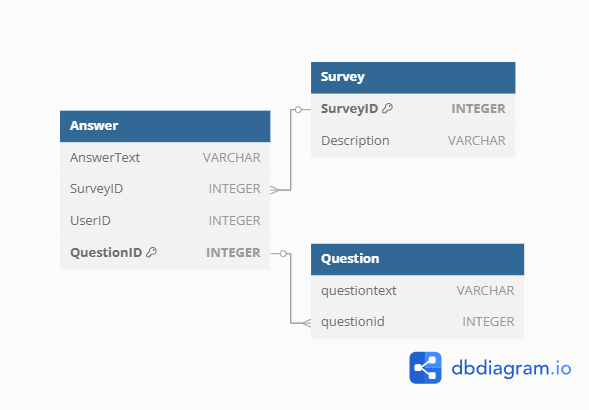

---
# Methodoligy

---
# Functions

Here we have a collection of custom functions that allow us to automate repetative code blocks. When a function is used, a note will be placed above the section it is used in.

In [3]:
def normalize_gender(gender):
    '''
    ---
    this function replaces the wide range of answers given for `What is your gender?` to a smaller set of answers:
    male, female, trans, non_binary, prefer not to say and other.
    ---
    this function is to be used with the .apply() function and must be used with the `AnswerText` column.
    ---
    use example : df['col'] = df['col'].apply(normalize_gender)
    
    output : a cleaned dataframe with all answers normalized to the given return statements.
    ---
    requirments : a df(str)
    ---
    '''

    g = gender.lower().strip()
    if g in ['male', 'man', 'cis male', 'cis man', 'masculine', 'm', 'mail', 'cis-male', 'cis-man', 'cis-mail']:
        return 'male'
    elif g in ['female', 'f', 'woman', 'cis female', 'cis woman', 'femanine', 'cis-female', 'cis-woman', 'cis-femail']:
        return 'female'
    elif 'trans' in g:
        return 'trans'
    elif 'non-binary' in g or 'genderqueer' in g or 'genderfluid' in g:
        return 'non-binary'
    elif g in ['na', 'n/a', '', 'none', 'no']:
        return 'prefer not to say'
    else:
        return 'other'

In [4]:
def calc_percent(df, col):
    '''
    ---
    this function is used to calculate the percentage in a given column for each unique input. 
    ---
    output : engineer is 20% of the answers given.
    ---
    requirements : what df(str) to act upon. this df must be created from the given sql file and MUST have count() as count in the query, 
    as the code relies on a count column. also requires what col(str) to act upon.
    ---
    '''
    
    df = df
    
    for index, row in df.iterrows():
        data = row[col]
        s = df[df[col] == data]['count'].values[0]
        l = sum(df['count'])
        t = round((s / l) * 100, 2)
        print(f'{data} is {t} % of this survey, siting at {s} in total.\n---')

In [5]:
def calc_percent_gender(df, col):
    '''
    ---
    this function works identically to calc_percent, however had to be modified for gender calculations as the query used to create
    the gender df was not working properly when using count when attempting to create a plot with the data.
    ---
    output : male is 40% of the answers given in this survey.
    ---
    requirments : what df(str) to act upon. when this df is created with an sql query, it CANNOT have count used in the select statement,
    as this causes issues with plotting. also requires what col(str) to act upon.
    ---
    '''
    
    counts = df[col].value_counts()

    t = len(df)

    for val in counts.index:
        count = counts[val]
        p = round((count / t) * 100, 2)
        print(f'{val} is {p} % of this survey, sitting at {count} in total.\n---')

In [6]:
def normalize_benefits(benefits):
    '''
    ---
    this function replaces the wide range of answers given for `Does your employer provide mental health benefits as part of healthcare coverage?` 
    and 'Have your previous employers provided mental health benefits?' to a smaller set of answers:
    yes, no, unknown and some. 
    ---
    this function is to be used with the .apply() function and must be used with the `AnswerText` column.
    ---
    use example : df['col'] = df['col'].apply(normalize_benefits)

    output : a cleaned dataframe with all answers normalized using the given return statements.
    ---
    requirments : a df(str)
    ---
    '''
    
    
    
    b = benefits.lower().strip()

    if "don't" in b:
        return 'unknown'
    elif 'yes' in b:
        return 'yes'
    elif 'no' in b:
        return 'no'
    elif 'not' in b:
        return 'no'
    elif 'some' in b:
        return 'some did'
    else :
        return 'unknown'

# Exploritory Data Analysis

In [7]:
conn = sqlite3.connect('mental_health.sqlite')

In [8]:
tables_query = "select name from sqlite_master where type = 'table';"
tables = pd.read_sql(tables_query, conn)
tables

,name
0,Answer
1,Question
2,Survey


In [9]:
pd.read_sql('''
select *
from Question;
''', conn)

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [10]:
pd.read_sql('''
select *
from Answer;
''', conn)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


In [11]:
pd.read_sql('''
select *
from Survey;
''', conn)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [12]:
pd.read_sql('''
select userid
from answer
''',conn)

,UserID
0,1
1,2
2,3
3,4
4,5
...,...
236893,2689
236894,2690
236895,2691
236896,2692


In [13]:
pd.read_sql('''
select answertext as answer, count(*) as count
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'What is your gender?'
group by a.answertext
order by count desc
''',conn)

,answer,count
0,Male,2830
1,Female,914
2,male,212
3,female,110
4,-1,24
...,...,...
96,Agender/genderfluid,1
97,Agender trans woman,1
98,AFAB,1
99,A little about you,1


---
# Data Insight

- Gender and Age Spread

- Industry Representation
 
- Mental Health

- Workplace Culture

## Gender breakdown

In [14]:
pd.read_sql('''
select answertext, count(*) as count
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'What is your gender?'
group by a.answertext
order by count desc
''', conn)

,AnswerText,count
0,Male,2830
1,Female,914
2,male,212
3,female,110
4,-1,24
...,...,...
96,Agender/genderfluid,1
97,Agender trans woman,1
98,AFAB,1
99,A little about you,1


In [15]:
df_gender_spread = pd.read_sql('''
select answertext
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'What is your gender?'
''', conn)

In [16]:
df_gender_spread

,AnswerText
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
4213,something kinda male?
4214,sometimes
4215,trans woman
4216,transgender


In [17]:
#df_gender_spread['gender'].value_counts().head(20)

In [18]:
# This cell is used to display the wide range of different answers for `what is your gender?`.
# Remove the pound symbols below to see the result

#with pd.option_context('display.max_rows', None):
#    print(df_gender_spread.value_counts())

- Function utilized:
    - `normalize_gender`
        - reduces the wide range of answers to a few that can be used for analysis.

In [19]:
df_gender_spread['AnswerText'] = df_gender_spread['AnswerText'].apply(normalize_gender)

In [20]:
with pd.option_context('display.max_rows', None):
    print(df_gender_spread.value_counts())

AnswerText       
male                 3044
female               1024
other                 102
non-binary             27
trans                  17
prefer not to say       4
Name: count, dtype: int64


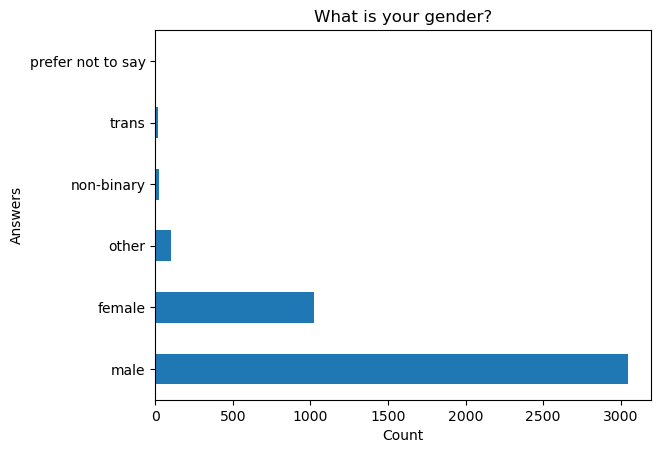

In [21]:
fig, ax = plt.subplots()

df_gender_spread['AnswerText'].value_counts().plot( kind = 'barh')

ax.set_title('What is your gender?')
ax.set_xlabel('Count')
ax.set_ylabel('Answers')

plt.show();

- function utilized:
    - `calc_percent_gender`
        - calculates the percent total for each gender

In [22]:
calc_percent_gender(df_gender_spread, 'AnswerText')

male is 72.17 % of this survey, sitting at 3044 in total.
---
female is 24.28 % of this survey, sitting at 1024 in total.
---
other is 2.42 % of this survey, sitting at 102 in total.
---
non-binary is 0.64 % of this survey, sitting at 27 in total.
---
trans is 0.4 % of this survey, sitting at 17 in total.
---
prefer not to say is 0.09 % of this survey, sitting at 4 in total.
---


## Age Spread

In [23]:
pd.read_sql('''
select answertext
from answer as a 
left join question as q 
on a.questionid = q.questionid
where questiontext = 'What is your age?'
group by answertext;
''', conn)

,AnswerText
0,-1
1,-29
2,0
3,11
4,15
...,...
60,70
61,72
62,74
63,8


In [24]:
df_age_spread = pd.read_sql('''
select cast(answertext as integer) as age
from answer as a 
left join question as q 
on a.questionid = q.questionid
where q.questiontext = 'What is your age?' and
age between 1 and 80
group by age
order by age asc;
''', conn)

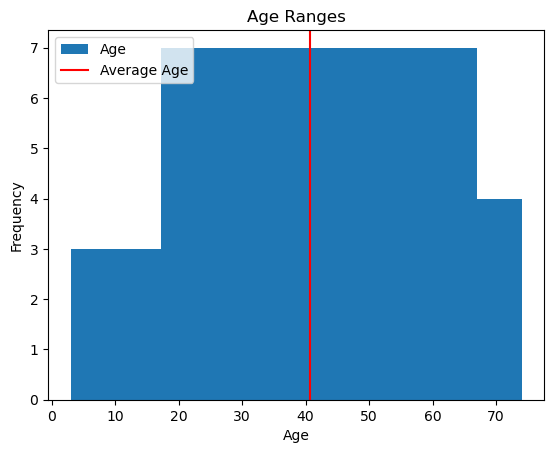

In [25]:
fig, ax = plt.subplots()

df_age_spread['age'].astype(int).plot(kind = 'hist')
avg_age = round(sum(df_age_spread['age']) / len(df_age_spread['age']), 1)

ax.axvline(avg_age, color = 'r')
ax.set_xlabel('Age')
ax.set_title('Age Ranges')
plt.legend(['Age','Average Age'])
plt.show();

In [26]:
avg_age

40.7

In [27]:
print(f'25% of ages are below {np.percentile(df_age_spread['age'], 25)}')
print(f'50% of ages are below {np.percentile(df_age_spread['age'], 50)}')
print(f'75% of ages are below {np.percentile(df_age_spread['age'], 75)}')

25% of ages are below 26.5
50% of ages are below 41.0
75% of ages are below 55.5


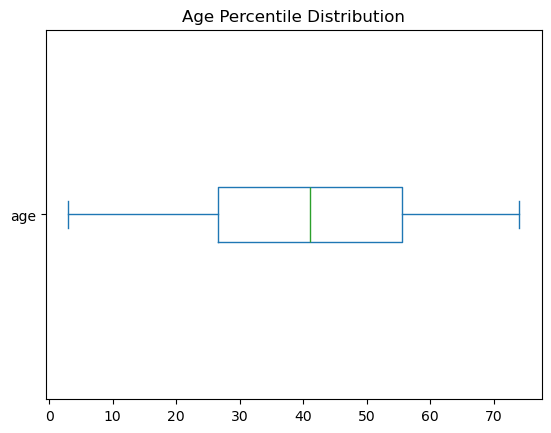

In [28]:
fig, ax = plt.subplots()

df_age_spread['age'].plot(kind = 'box', vert = False)

ax.set_title('Age Percentile Distribution')
plt.show();

---
## Industry Representation

In [29]:
df_question = pd.read_sql('''
select questiontext
from question as q
''',conn)

In [30]:
# This cell is used to display all of the questions contained in this survey.
# Remove the pound symbols below to see the result

#pd.set_option('display.max_colwidth', None)
#for f in df_question.iterrows():
#    print(f)

In [31]:
pd.option_context('display.max_colwidth', None)

In [32]:
pd.read_sql('''
select questiontext
from question as q
where questionid = 9
''',conn)

,questiontext
0,Is your employer primarily a tech company/orga...


In [33]:
pd.read_sql('''
select answertext, count(answertext) as count
from answer as a 
where questionid = 9
group by answertext
''',conn)

,AnswerText,count
0,-1,504
1,0,826
2,1,2888


In [34]:
pd.read_sql('''
select questiontext
from question as q
where questionid = 13
''',conn)

,questiontext
0,Is your primary role within your company relat...


In [35]:
pd.read_sql('''
select answertext, count(answertext) as count
from question as q
left join answer as a
 on q.questionid = a.questionid
where q.questionid = 13
group by answertext
''',conn)

,AnswerText,count
0,-1,1387
1,0,100
2,1,1471


In [36]:
pd.read_sql('''
select questiontext
from question
where questiontext = 'Which of the following best describes your work position?'
''',conn)

,questiontext
0,Which of the following best describes your wor...


In [37]:
pd.reset_option('display.max_colwidth')

In [38]:
pd.read_sql('''
select answertext, count(answertext) as count
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'Which of the following best describes your work position?'
group by answertext
order by count desc
''',conn)

,AnswerText,count
0,Back-end Developer,737
1,Front-end Developer,502
2,DevOps/SysAdmin,282
3,Supervisor/Team Lead,277
4,Other,187
5,Support,168
6,One-person shop,161
7,Designer,135
8,Executive Leadership,101
9,Dev Evangelist/Advocate,99


In [39]:
job_spread = pd.read_sql('''
select answertext as job, count(answertext) as count
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'Which of the following best describes your work position?'
group by job
order by count desc
''',conn)

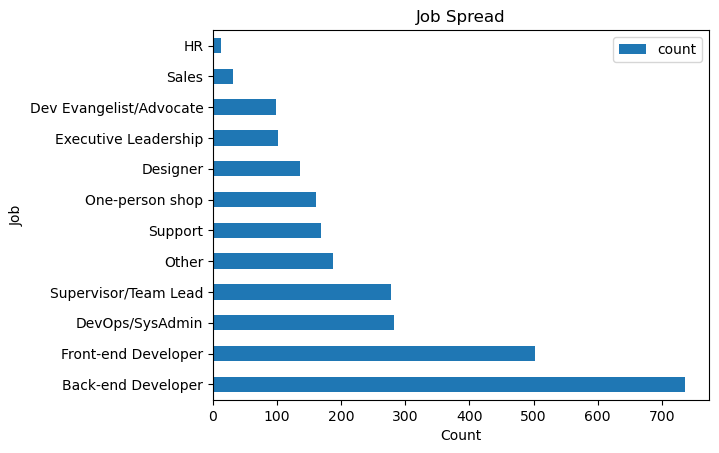

In [40]:
fig, ax = plt.subplots()
job_spread.plot(x = 'job', kind = 'barh', ax = ax)

ax.set_title('Job Spread')
ax.set_xlabel('Count')
ax.set_ylabel('Job')
plt.show();

- function utilized:
    - `calc_percent`
        - calcualtes the percentage of each unique input for a given column

In [41]:
calc_percent(job_spread, 'job')

Back-end Developer is 27.38 % of this survey, siting at 737 in total.
---
Front-end Developer is 18.65 % of this survey, siting at 502 in total.
---
DevOps/SysAdmin is 10.48 % of this survey, siting at 282 in total.
---
Supervisor/Team Lead is 10.29 % of this survey, siting at 277 in total.
---
Other is 6.95 % of this survey, siting at 187 in total.
---
Support is 6.24 % of this survey, siting at 168 in total.
---
One-person shop is 5.98 % of this survey, siting at 161 in total.
---
Designer is 5.01 % of this survey, siting at 135 in total.
---
Executive Leadership is 3.75 % of this survey, siting at 101 in total.
---
Dev Evangelist/Advocate is 3.68 % of this survey, siting at 99 in total.
---
Sales is 1.15 % of this survey, siting at 31 in total.
---
HR is 0.45 % of this survey, siting at 12 in total.
---


---
## Mental Health 

In [42]:
pd.set_option('display.max_colwidth', None)
for f in df_question.iterrows():
    print(f)

(0, questiontext    What is your age?
Name: 0, dtype: object)
(1, questiontext    What is your gender?
Name: 1, dtype: object)
(2, questiontext    What country do you live in?
Name: 2, dtype: object)
(3, questiontext    If you live in the United States, which state or territory do you live in?
Name: 3, dtype: object)
(4, questiontext    Are you self-employed?
Name: 4, dtype: object)
(5, questiontext    Do you have a family history of mental illness?
Name: 5, dtype: object)
(6, questiontext    Have you ever sought treatment for a mental health disorder from a mental health professional?
Name: 6, dtype: object)
(7, questiontext    How many employees does your company or organization have?
Name: 7, dtype: object)
(8, questiontext    Is your employer primarily a tech company/organization?
Name: 8, dtype: object)
(9, questiontext    Does your employer provide mental health benefits as part of healthcare coverage?
Name: 9, dtype: object)
(10, questiontext    Is your anonymity protected if yo

34, Have you ever been diagnosed with a mental health disorder?

In [43]:
mental_health_df = pd.read_sql('''
select answertext, count(answertext) as count
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'Have you ever been diagnosed with a mental health disorder?'
group by answertext
''',conn)

In [44]:
mental_health_df = mental_health_df.replace({'-1' : 'prefer not to say'})

In [45]:
mental_health_df

,AnswerText,count
0,prefer not to say,863
1,No,732
2,Yes,1363


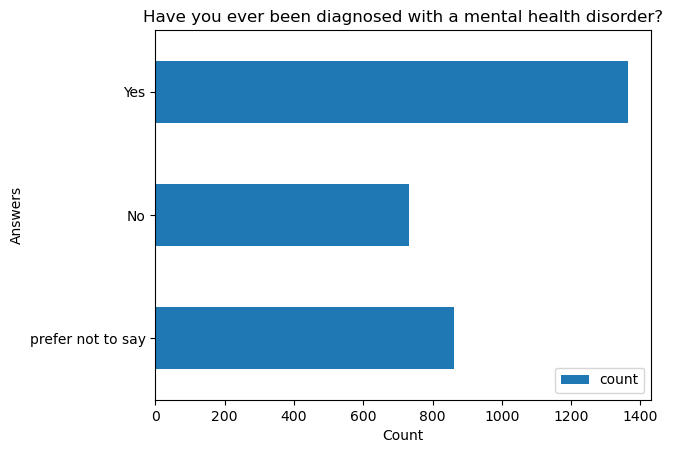

In [46]:
fig, ax = plt.subplots()

mental_health_df.plot(x = 'AnswerText', kind = 'barh', ax = ax)

ax.set_title('Have you ever been diagnosed with a mental health disorder?')
ax.set_ylabel('Answers')
ax.set_xlabel('Count')
plt.show();

In [47]:
calc_percent(mental_health_df, 'AnswerText')

prefer not to say is 29.18 % of this survey, siting at 863 in total.
---
No is 24.75 % of this survey, siting at 732 in total.
---
Yes is 46.08 % of this survey, siting at 1363 in total.
---


### Mental health by age, gender and job type

### Age

In [48]:
# 1 34
pd.read_sql('''
select questionid, questiontext
from question
where questiontext like '%age%' or questiontext like '%diagnose%'
''',conn)

,questionid,questiontext
0,1,What is your age?
1,10,Does your employer provide mental health benefits as part of healthcare coverage?
2,11,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
3,14,Do you know the options for mental health care available under your employer-provided health coverage?
4,20,Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?
5,27,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?
6,34,Have you ever been diagnosed with a mental health disorder?
7,52,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?"
8,53,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?"
9,55,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?"


In [49]:
age_diagnosis = pd.read_sql('''
select a1.answertext as age, a2.answertext as diagnosis
from answer as a1
left join answer as a2
on a1.userid = a2.userid
where a1.questionid = 1 and
a2.questionid = 34 and 
age between 19 and 60 
''',conn)

In [50]:
age_diagnosis.head()

,age,diagnosis
0,39,Yes
1,29,Yes
2,38,No
3,43,Yes
4,43,Yes


In [51]:
age_diagnosis = age_diagnosis.replace({'-1': 'prefer not to say'})

In [52]:
age_diagnosis[age_diagnosis['age'] == '323']

,age,diagnosis
559,323,No


In [53]:
age_diagnosis = age_diagnosis.replace({'323' : '32'})

In [54]:
age_diagnosis[age_diagnosis['age'] == '3']

,age,diagnosis
650,3,Yes


In [55]:
age_diagnosis.drop(650, inplace = True)

In [56]:
counts_a = age_diagnosis.groupby(['age', 'diagnosis']).size().unstack(fill_value = 0)

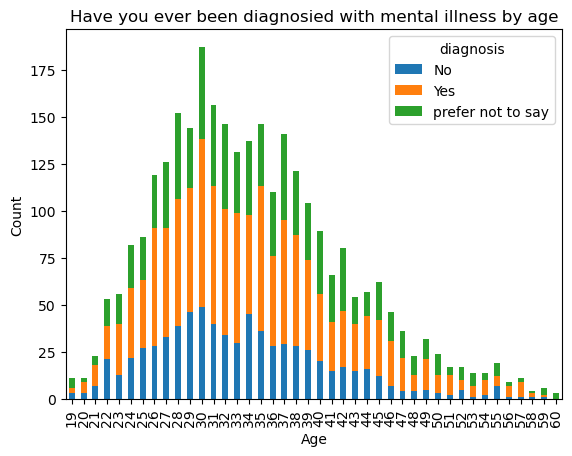

In [57]:
fig, ax = plt.subplots()

counts_a.plot(kind = 'bar', stacked = True, ax = ax)
ax.set_title('Have you ever been diagnosied with mental illness by age')
ax.set_ylabel('Count')
ax.set_xlabel('Age')
plt.show();

### Gender

In [58]:
pd.read_sql('''
select questionid, questiontext
from question
where questiontext like '%gender%' or questiontext like '%diagnose%'
''',conn)

,questionid,questiontext
0,2,What is your gender?
1,34,Have you ever been diagnosed with a mental health disorder?
2,52,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?"
3,53,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?"
4,115,"If yes, what condition(s) have you been diagnosed with?"


In [59]:
# 2 34
gender_diagnosis = pd.read_sql('''
select a1.answertext as gender, a2.answertext as diagnosis
from answer as a1
left join answer as a2
on a1.userid = a2.userid
where a1.questionid = 2 and
a2.questionid = 34 
''',conn)

In [60]:
gender_diagnosis.head()

,gender,diagnosis
0,Male,Yes
1,Male,Yes
2,Male,No
3,Male,Yes
4,Female,Yes


In [61]:
gender_diagnosis['gender'] = gender_diagnosis['gender'].apply(normalize_gender)

In [62]:
gender_diagnosis = gender_diagnosis.replace({'-1' : 'prefer not to say'})

In [63]:
gender_diagnosis.value_counts()

gender             diagnosis        
male               Yes                  826
                   prefer not to say    628
                   No                   599
female             Yes                  457
                   prefer not to say    197
                   No                   123
other              Yes                   51
                   prefer not to say     28
non-binary         Yes                   19
trans              Yes                    9
other              No                     7
non-binary         prefer not to say      4
prefer not to say  prefer not to say      3
trans              prefer not to say      3
non-binary         No                     2
prefer not to say  Yes                    1
trans              No                     1
Name: count, dtype: int64

In [64]:
counts_g = gender_diagnosis.groupby(['gender', 'diagnosis']).size().unstack(fill_value = 0)

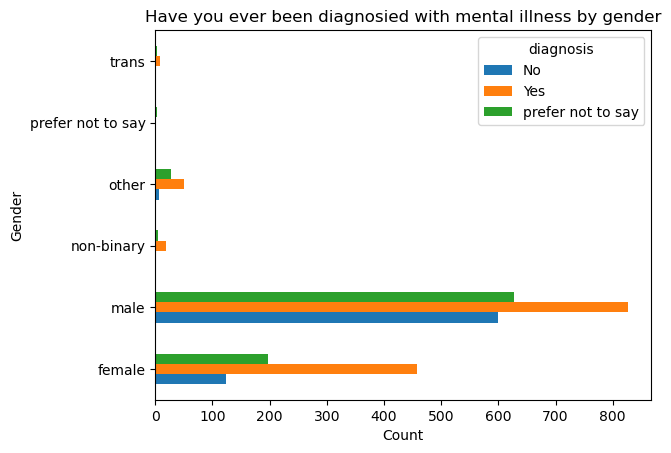

In [65]:
fig, ax = plt.subplots()

counts_g.plot(kind = 'barh', stacked = False, ax = ax)
ax.set_title('Have you ever been diagnosied with mental illness by gender')
ax.set_xlabel('Count')
ax.set_ylabel('Gender')
plt.show();

### Job Type

In [66]:
# 117 34
pd.read_sql('''
select questionid, questiontext
from question
where questiontext like '%position%' or questiontext like '%diagnose%'
''',conn)

,questionid,questiontext
0,34,Have you ever been diagnosed with a mental health disorder?
1,52,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?"
2,53,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?"
3,115,"If yes, what condition(s) have you been diagnosed with?"
4,117,Which of the following best describes your work position?


In [67]:
work_diagnosis = pd.read_sql('''
select a1.answertext as job, a2.answertext as diagnosis
from answer as a1
left join answer as a2
on a1.userid = a2.userid
where a1.questionid = 117 and
a2.questionid = 34 
''',conn)

In [68]:
work_diagnosis.value_counts()

job                      diagnosis
Back-end Developer       No           381
                         Yes          356
Front-end Developer      No           260
                         Yes          242
DevOps/SysAdmin          No           150
Supervisor/Team Lead     No           141
                         Yes          136
DevOps/SysAdmin          Yes          132
Other                    Yes          100
                         No            87
Support                  Yes           87
Designer                 Yes           86
One-person shop          Yes           82
Support                  No            81
One-person shop          No            79
Dev Evangelist/Advocate  Yes           53
Executive Leadership     No            52
                         Yes           49
Designer                 No            49
Dev Evangelist/Advocate  No            46
Sales                    Yes           16
                         No            15
HR                       Yes            7

In [69]:
counts_j = work_diagnosis.groupby(['job', 'diagnosis']).size().unstack(fill_value = 0)

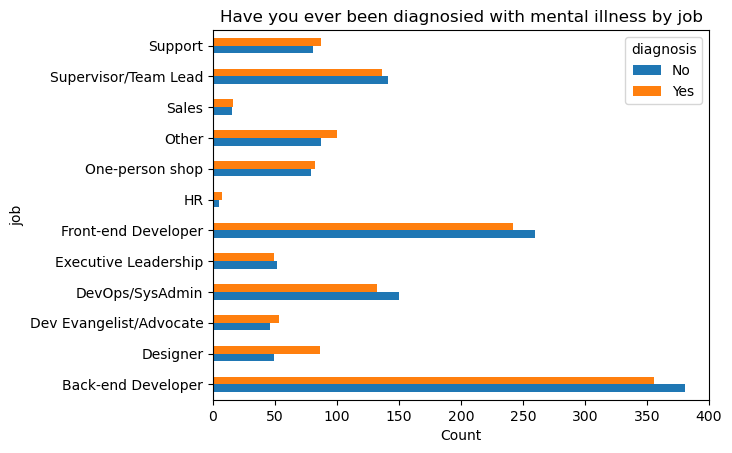

In [70]:
fig, ax = plt.subplots()

counts_j.plot(kind = 'barh', stacked = False, ax = ax)
ax.set_title('Have you ever been diagnosied with mental illness by job')
ax.set_xlabel('Count')
plt.show();

---
## Workplace Culture

### Current Employer

In [71]:
pd.read_sql('''
select questiontext
from question
where questiontext like '%benefits%'
''', conn)

,questiontext
0,Does your employer provide mental health benefits as part of healthcare coverage?
1,Have your previous employers provided mental health benefits?


In [72]:
benefits_df = pd.read_sql('''
select answertext
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'Does your employer provide mental health benefits as part of healthcare coverage?'
''',conn)

benefits_df.value_counts()

AnswerText                    
Yes                               1744
No                                 756
I don't know                       658
-1                                 504
Don't know                         408
Not eligible for coverage / NA     148
Name: count, dtype: int64

In [73]:
benefits_df['AnswerText'] = benefits_df['AnswerText'].apply(normalize_benefits)

In [74]:
benefits_df.value_counts()

AnswerText
yes           1744
unknown       1570
no             904
Name: count, dtype: int64

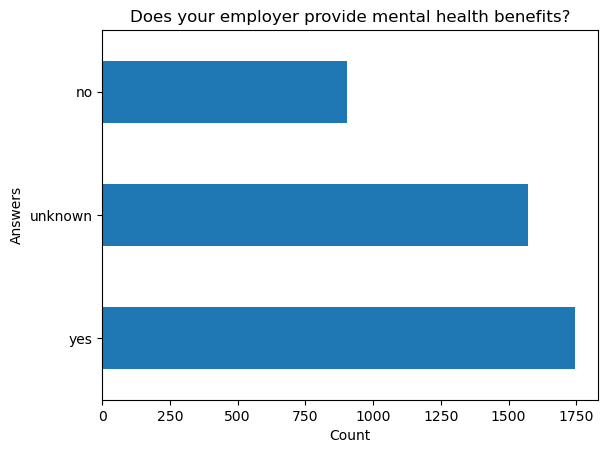

In [75]:
fig, ax = plt.subplots()

benefits_df['AnswerText'].value_counts().plot(kind = 'barh')

ax.set_title('Does your employer provide mental health benefits?')
ax.set_ylabel('Answers')
ax.set_xlabel('Count')

plt.show();

### Past Employer

In [76]:
pd.read_sql('''
select questiontext
from question
where questiontext like '%benefits%'
''', conn)

,questiontext
0,Does your employer provide mental health benefits as part of healthcare coverage?
1,Have your previous employers provided mental health benefits?


In [77]:
past_df = pd.read_sql('''
select answertext
from answer as a
left join question as q
on a.questionid = q.questionid
where questiontext = 'Have your previous employers provided mental health benefits?'
''', conn)

past_df.value_counts()

AnswerText       
Some did             852
No, none did         700
I don't know         619
Yes, they all did    419
-1                   368
Name: count, dtype: int64

In [78]:
past_df['AnswerText'] = past_df['AnswerText'].apply(normalize_benefits)
past_df.value_counts()

AnswerText
unknown       987
some did      852
no            700
yes           419
Name: count, dtype: int64

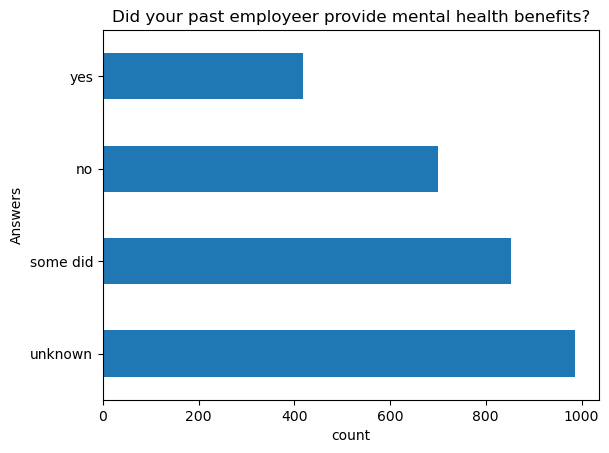

In [79]:
fig, ax = plt.subplots()

past_df['AnswerText'].value_counts().plot(kind = 'barh')

ax.set_title('Did your past employeer provide mental health benefits?')
ax.set_ylabel('Answers')
ax.set_xlabel('count')
plt.show();

## Support

In [80]:
pd.read_sql('''
select questiontext
from question
where questiontext like '%support%'
''',conn)

,questiontext
0,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
1,Describe the circumstances of the badly handled or unsupportive response.
2,Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?
3,Describe the circumstances of the supportive or well handled response.
4,"Overall, how well do you think the tech industry supports employees with mental health issues?"
5,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.


In [81]:
support_df = pd.read_sql('''
select answertext
from answer as a 
left join question as q
on a.questionid = q.questionid
where questiontext = 'Overall, how well do you think the tech industry supports employees with mental health issues?'
''',conn)
support_df.value_counts()

AnswerText
3             597
2             494
1             217
4             191
5              24
-1              2
Name: count, dtype: int64

Here we can see a mistake in the data gathering process, where the answers to "Overall, how well do you think the tech industry supports employees with mental health issues?" were answered with numbers, without a decoder given. Working with this specific `AnswerText` is now nearly impossible. We could apply a logic decoder to it to mimic the data spread of previous answers, but that could be completely random as well as misleading. This is a great example of why answers should not be open ended, and should rather be multiple choice. 